In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [2]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = 'D:/ML Summer Learning/Code/Autoencoder/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 9.91M/9.91M [00:16<00:00, 587kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 120kB/s]
100%|██████████| 1.65M/1.65M [00:08<00:00, 190kB/s] 
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


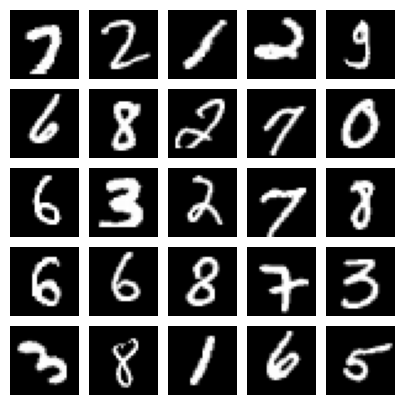

In [3]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [4]:
device

device(type='cuda')

In [9]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.device = device

        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.mean_layer = nn.Linear(self.hidden_dim, self.latent_dim)
        self.log_var_layer = nn.Linear(self.hidden_dim, self.latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(self.hidden_dim, self.input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mean = self.mean_layer(h)
        log_var = self.log_var_layer(h)
        return mean, log_var
    
    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, log_var = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mean, log_var

def loss_function(reconstructed_x, x, mean, log_var):
    # reproduction_loss = nn.funtional.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    reproduction_loss = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + kl_divergence


In [10]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
model.train()
num_epochs = 20
for epoch in range(num_epochs):
    overall_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 784).to(device)
        optimizer.zero_grad()
        reconstructed_data, mean, log_var = model(data)
        loss = loss_function(reconstructed_data, data, mean, log_var)
        loss.backward()
        optimizer.step()
        overall_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {overall_loss/ len(train_loader.dataset):.4f}')

# print("Overall Loss: ", overall_loss)


Epoch [1/20], Loss: 173.7969
Epoch [2/20], Loss: 129.2522
Epoch [3/20], Loss: 117.7937
Epoch [4/20], Loss: 112.6656
Epoch [5/20], Loss: 110.0421
Epoch [6/20], Loss: 108.2050
Epoch [7/20], Loss: 106.8064
Epoch [8/20], Loss: 105.8071
Epoch [9/20], Loss: 105.0674
Epoch [10/20], Loss: 104.5659
Epoch [11/20], Loss: 104.0309
Epoch [12/20], Loss: 103.6081
Epoch [13/20], Loss: 103.2183
Epoch [14/20], Loss: 102.9419
Epoch [15/20], Loss: 102.6645
Epoch [16/20], Loss: 102.3810
Epoch [17/20], Loss: 102.0975
Epoch [18/20], Loss: 101.9977
Epoch [19/20], Loss: 101.7840
Epoch [20/20], Loss: 101.5552


In [12]:
test_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: D:/ML Summer Learning/Code/Autoencoder/datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [13]:
test_data = test_dataset.data[:100]
test_data.shape

torch.Size([100, 28, 28])

In [14]:
test_data = test_data.view(-1, 784).float() / 255.0
test_data = test_data.to(device)
with torch.no_grad():
    reconstructed_data, mean, log_var = model(test_data)
reconstructed_data = reconstructed_data.view(-1, 1, 28, 28)
save_image(reconstructed_data, 'reconstructed_images.png', nrow=10, normalize=True)

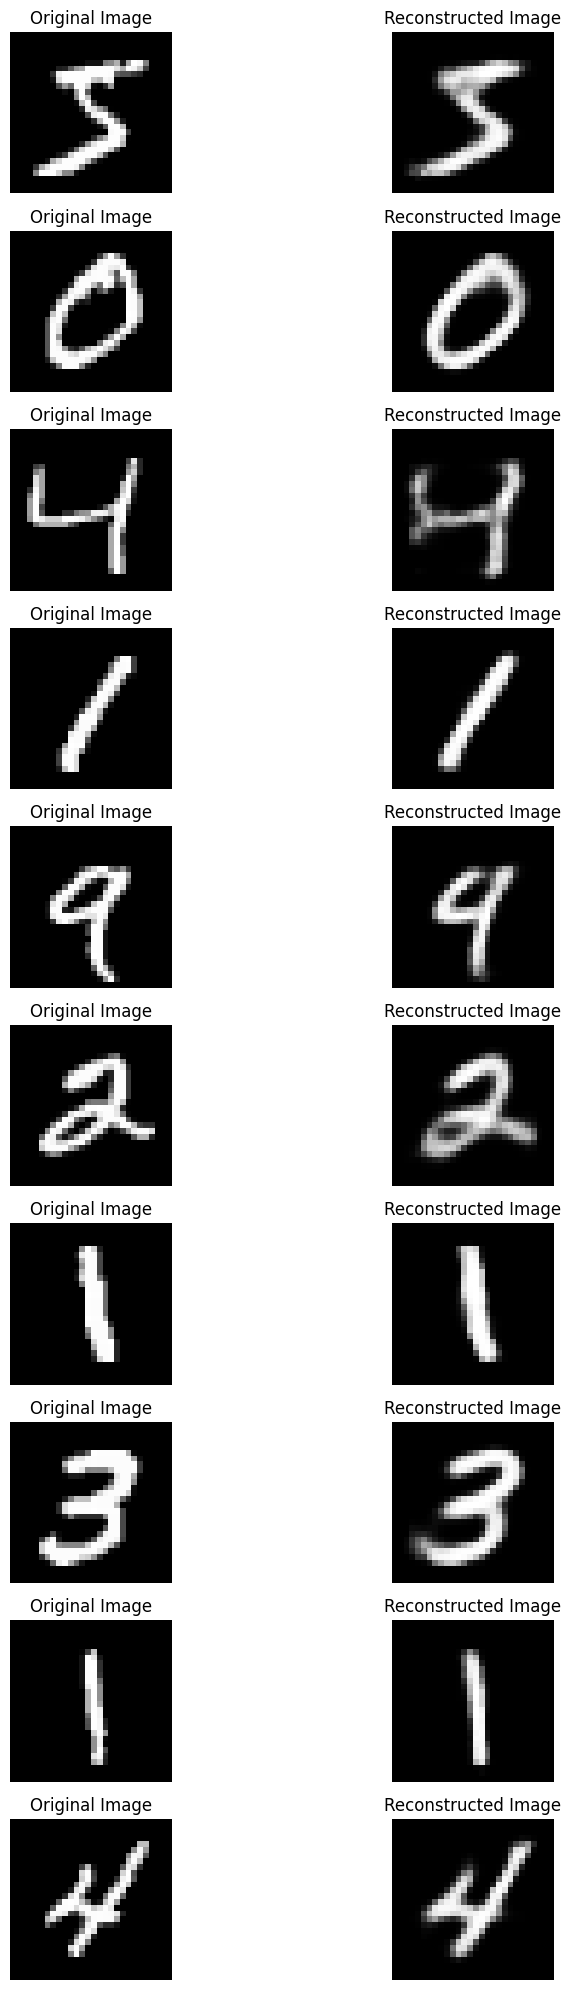

In [15]:
# Visualize the reconstructed images vs original images
fig, axes = plt.subplots(10, 2, figsize=(10, 20))
for i in range(10):
    axes[i, 0].imshow(test_data[i].view(28, 28).cpu().numpy(), cmap='gray')
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(reconstructed_data[i].view(28, 28).cpu().numpy(), cmap='gray')
    axes[i, 1].set_title('Reconstructed Image')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()


In [18]:
mean.shape, log_var.shape

(torch.Size([100, 200]), torch.Size([100, 200]))

In [19]:
var = torch.exp(log_var)

# get the latent space distribution z = mean + std * eps

latent_space = torch.randn(100, 200).to(device)
z = mean + torch.randn_like(var) * torch.sqrt(var)
z

tensor([[ 0.4901, -0.2685, -0.9070,  ..., -2.0905,  0.2517,  0.5819],
        [ 1.7394, -1.1730,  1.1956,  ..., -0.2322,  0.3307,  1.2727],
        [-0.6899,  0.5541, -0.1406,  ...,  0.2579, -0.3032, -1.1321],
        ...,
        [ 1.2224,  0.7945, -0.4726,  ..., -0.5616,  1.1316,  0.2103],
        [-0.3184, -0.6952,  0.0385,  ...,  1.7827, -1.2983, -0.6043],
        [ 2.0610,  0.0387, -2.3635,  ...,  0.8708, -0.4943,  2.2617]],
       device='cuda:0')

In [20]:
z.shape

torch.Size([100, 200])

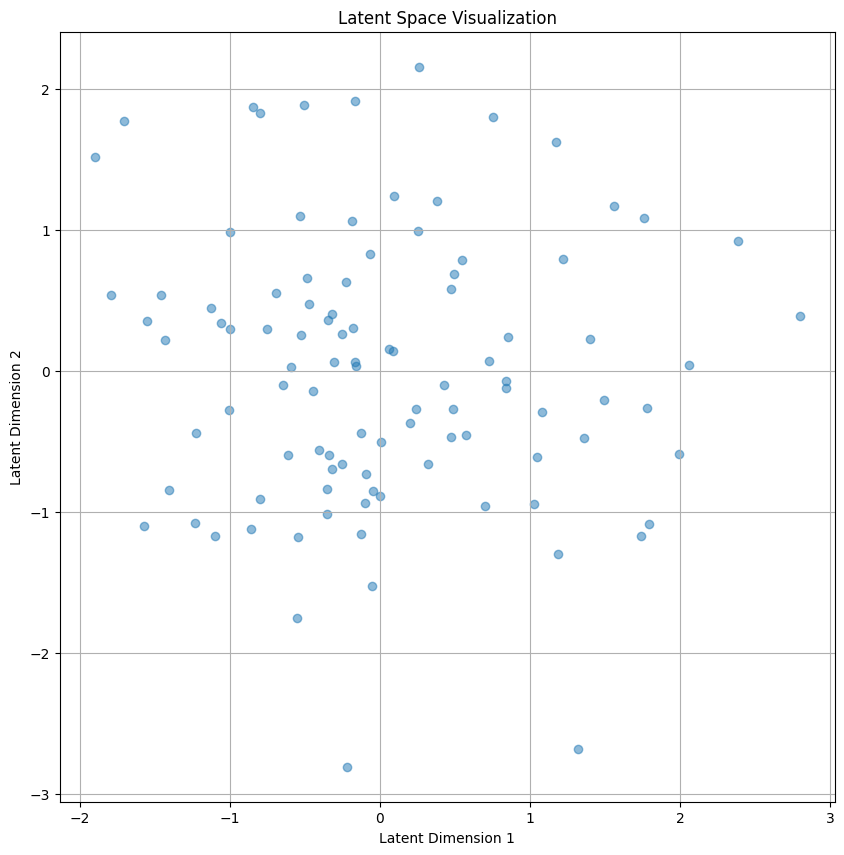

In [24]:
z[0].shape
# Visualize the full latent space
plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0].cpu().numpy(), z[:, 1].cpu().numpy(), alpha=0.5)
plt.title('Latent Space Visualization')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid()
plt.show()